In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T
from torchvision.models.optical_flow import raft_large

from lumivid.utils.video_utils import get_video, get_video_frame_iterator
from lumivid.gsam.gsam import get_segmentation_masks_from, get_gdino_model, get_sam_predictor, get_segmentation_mask_color, show_bounding_boxes, TYPE_COLORS

DATA_PATH = '../data/'
FRAME_STEP = 25
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def get_optical_flow_model():
    return raft_large(weights='C_T_SKHT_V2').to(DEVICE)

def get_flow(optical_flow_model, rgb_frame1, rgb_frame2, shape_factor=2, multiple=8):
    optical_flow_model.eval()

    old_shape = (rgb_frame1.shape[0], rgb_frame1.shape[1])
    new_shape = ((old_shape[0] // (shape_factor * multiple)) * multiple, (old_shape[1] // (shape_factor * multiple)) * multiple)

    # Get tensor from frame
    frame1_tensor = torch.from_numpy(rgb_frame1).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE)
    frame2_tensor = torch.from_numpy(rgb_frame2).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE)
    transforms = T.Compose([
        T.Lambda(lambda x: x / 255.0),      # [0, 255] to [0, 1]
        T.Normalize(mean=[0.5], std=[0.5]), # [0, 1] to [-1, 1]
        T.Resize(size=(new_shape[0], new_shape[1])),
    ])
    frame1_tensor = transforms(frame1_tensor)
    frame2_tensor = transforms(frame2_tensor)

    with torch.no_grad():
        optical_flow = optical_flow_model(frame1_tensor, frame2_tensor)
        optical_flow = optical_flow[0].squeeze().cpu().numpy()

        # Resize flow to original shape
        optical_flow = optical_flow.transpose(1, 2, 0)
        optical_flow = cv2.resize(optical_flow, (old_shape[1], old_shape[0]))

    # Free GPU memory
    del frame1_tensor
    del frame2_tensor
    torch.cuda.empty_cache()

    return optical_flow

def show_flow_segmentation(rgb_frame, segmentation_masks, class_ids, class_dict, optical_flow, step: int = 10, alpha: float = 0.5):
    # Tensor of masks into single mask with class ids
    all_segmentation_masks = np.zeros_like(segmentation_masks[0]).astype(np.int32)
    for i in range(segmentation_masks.shape[0]):
        segmentation_mask = segmentation_masks[i]
        class_id = class_ids[i]
        all_segmentation_masks[segmentation_mask] = class_id + 1

    # Map the segmentation classes to the corresponding colors
    segmentation_colors = get_segmentation_mask_color(all_segmentation_masks, class_dict)
    segmentation_colors = segmentation_colors.transpose(1, 2, 0)
    rgb_mixed = np.where(segmentation_colors.sum(axis=2)[..., np.newaxis] == 0, rgb_frame, rgb_frame * (1 - alpha) + segmentation_colors * alpha)
    rgb_mixed = rgb_mixed.astype(np.uint8)

    # Downsample the flow for a cleaner quiver plot
    optical_flow_downsampled = optical_flow[::step, ::step]
    y, x = np.mgrid[0:rgb_mixed.shape[0]:step, 0:rgb_mixed.shape[1]:step]

    # Get the colors for the downsampled segmentation at the points where we will place the quiver arrows
    colors_for_quiver = segmentation_colors[y.flatten(), x.flatten()]

    # Normalize the color values
    quiver_colors = colors_for_quiver / 255.0

    # Plot the flow vectors
    plt.figure(figsize=(20, 20))
    plt.quiver(x.flatten(), y.flatten(), optical_flow_downsampled[..., 0].flatten(), optical_flow_downsampled[..., 1].flatten(), 
               angles='xy', scale_units='xy', scale=0.25, color=quiver_colors, width=0.0015)
    plt.imshow(rgb_mixed, interpolation='none')
    plt.show()

In [4]:
def show_ground_statistics(
        video_path: str,
        gdino_model,
        sam_predictor,
        optical_flow_model,
        frame_step: int = 1,
        split: bool = False,
        masked: bool = False,
        reframed: bool = False
    ):
    video = get_video(video_path)
    frame_it = get_video_frame_iterator(
        video, 
        frame_step=frame_step,
        split = split,
        masked = masked,
        reframed = reframed
    )

    class_magnitudes = {}
    class_counts = {}

    previous_bgr_frame = None
    n_frames = 0
    for bgr_frame, _ in tqdm(frame_it):
        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

        # Reframe shape like previous frame if needed
        if previous_bgr_frame is not None and bgr_frame.shape != previous_bgr_frame.shape:
            bgr_frame = cv2.resize(bgr_frame, (previous_bgr_frame.shape[1], previous_bgr_frame.shape[0]))

        # Get statistics
        if previous_bgr_frame is not None:
            # Get segmentation mask
            detections, class_dict, class_to_types = get_segmentation_masks_from(gdino_model, sam_predictor, previous_bgr_frame)
            segmentation_masks = detections.mask
            class_ids = detections.class_id

            # Get optical flow
            previous_rgb_frame = cv2.cvtColor(previous_bgr_frame, cv2.COLOR_BGR2RGB)
            optical_flow = get_flow(optical_flow_model, previous_rgb_frame, rgb_frame)
            magnitudes = np.linalg.norm(optical_flow, axis=2)

            # Add magnitudes and count to corresponding class
            for i in range(segmentation_masks.shape[0]):
                segmentation_mask = segmentation_masks[i]
                class_id = class_ids[i] + 1

                # Get mean magnitude of detected object
                magnitudes_for_class = magnitudes[segmentation_mask]
                mean_magnitude = np.mean(magnitudes_for_class)

                # Add to class
                class_key = class_to_types[class_dict[class_id]]
                if class_key not in class_magnitudes:
                    class_magnitudes[class_key] = 0
                    class_counts[class_key] = 0
                class_magnitudes[class_key] += mean_magnitude
                class_counts[class_key] += 1

            # Show frames
            #show_bounding_boxes(previous_bgr_frame, detections)
            #show_flow_segmentation(previous_rgb_frame, segmentation_masks, class_ids, class_dict, optical_flow, step=10, alpha=0.5)

        previous_bgr_frame = bgr_frame
        n_frames += 1

    # Get magnitudes
    classes = ['person', 'vegetation', 'vehicle']
    class_magnitudes_keys = np.array([e for e in class_magnitudes.keys() if e in classes])
    class_magnitudes_values = np.array([class_magnitudes[key] for key in class_magnitudes_keys])
    class_magnitudes_values = class_magnitudes_values / n_frames

    # Sort by class name
    sorted_idx = np.argsort(class_magnitudes_keys)
    class_magnitudes_keys = class_magnitudes_keys[sorted_idx]
    class_magnitudes_values = class_magnitudes_values[sorted_idx]

    # Get mean number of objects per class
    mean_class_counts = {k: v / n_frames for k, v in class_counts.items()}

    # get colors
    colors = np.array([TYPE_COLORS[e] for e in class_magnitudes_keys]) / 255

    # Plot statistics
    plt.figure(figsize=(10, 5))
    plt.title('Object classes')
    object_bars = plt.bar(class_magnitudes_keys, class_magnitudes_values, color=colors)
    # Add text on top of each bar for object classes
    for bar, key in zip(object_bars, class_magnitudes_keys):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean_class_counts.get(key, 0):.2f}', # Format to 2 decimal places
                ha='center', va='bottom')
    plt.show()

    # Get dicts
    object_class_dict = {k: v for k, v in zip(class_magnitudes_keys, class_magnitudes_values)}

    return object_class_dict, mean_class_counts

In [5]:
gdino_model = get_gdino_model()
sam_predictor = get_sam_predictor()
optical_flow_model = get_optical_flow_model()

c:\Users\arnau\anaconda3\envs\a\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [6]:
final_statistics = {}

1it [00:00,  1.62it/s]c:\Users\arnau\anaconda3\envs\a\Lib\site-packages\transformers\modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\arnau\anaconda3\envs\a\Lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
c:\Users\arnau\anaconda3\envs\a\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

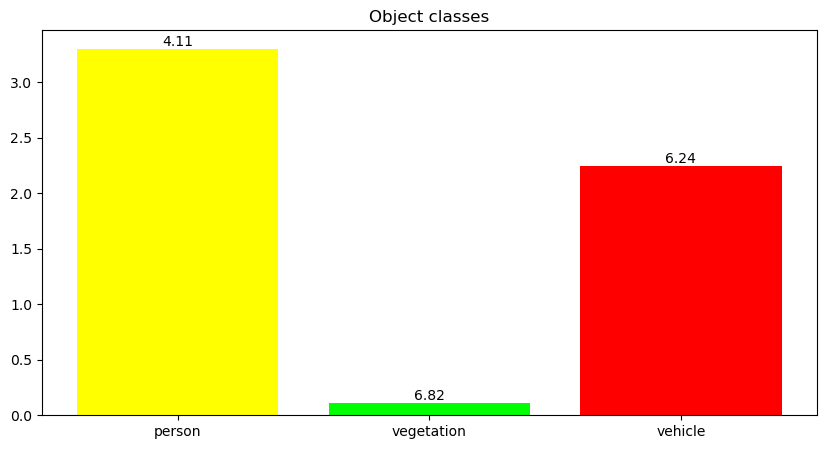

In [7]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P3Scene01.mp4"
object_class_dict, mean_class_counts = show_ground_statistics(video_path, gdino_model, sam_predictor, optical_flow_model, frame_step=FRAME_STEP, split=False, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'object_class_dict': object_class_dict, 'mean_class_counts': mean_class_counts}

120it [02:30,  1.25s/it]


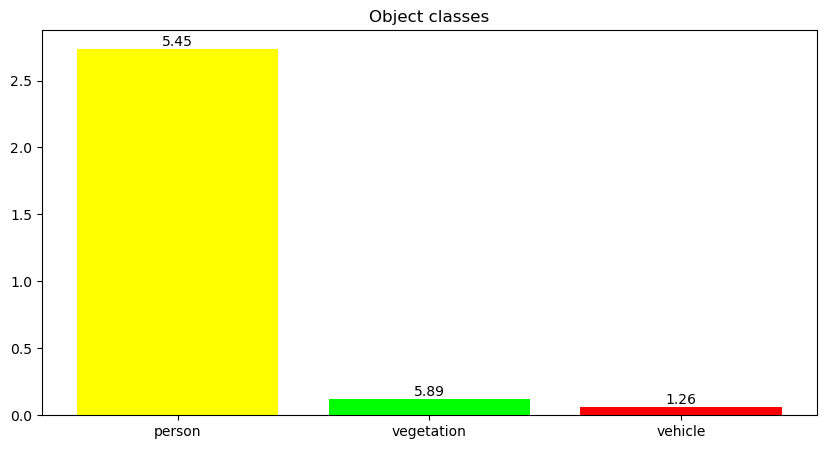

In [8]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P3Scene02.mp4"
object_class_dict, mean_class_counts = show_ground_statistics(video_path, gdino_model, sam_predictor, optical_flow_model, frame_step=FRAME_STEP, split=False, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'object_class_dict': object_class_dict, 'mean_class_counts': mean_class_counts}

120it [02:34,  1.29s/it]


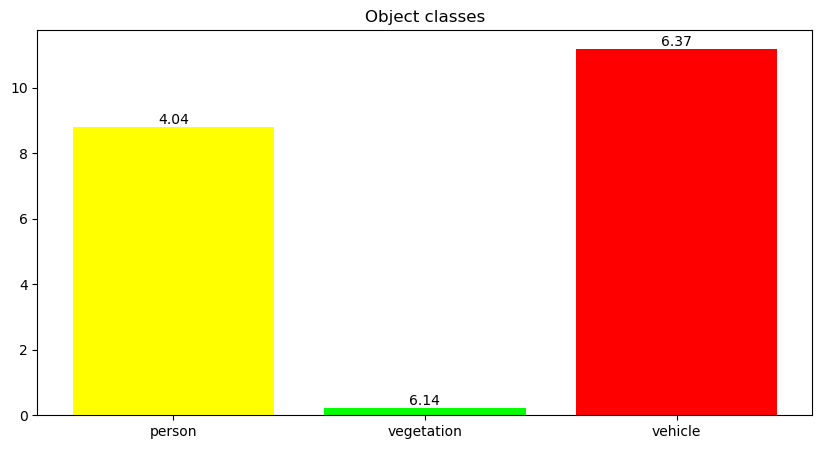

In [9]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P3Scene03.mp4"
object_class_dict, mean_class_counts = show_ground_statistics(video_path, gdino_model, sam_predictor, optical_flow_model, frame_step=FRAME_STEP, split=False, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'object_class_dict': object_class_dict, 'mean_class_counts': mean_class_counts}

121it [02:24,  1.19s/it]


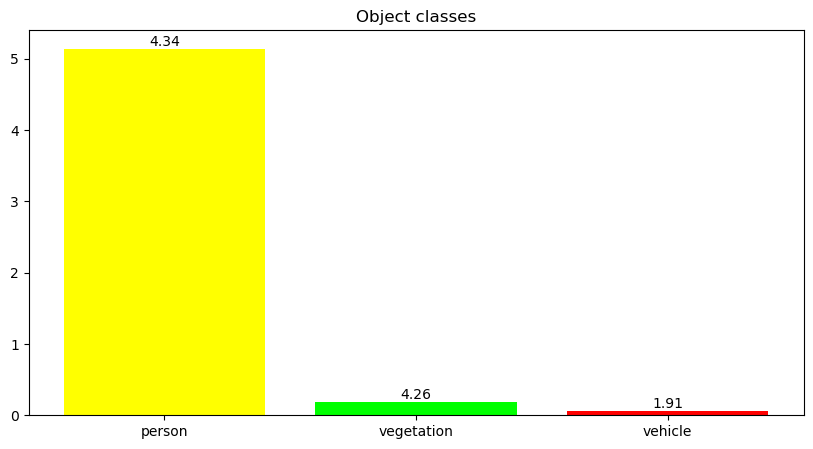

In [10]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P3Scene04.mp4"
object_class_dict, mean_class_counts = show_ground_statistics(video_path, gdino_model, sam_predictor, optical_flow_model, frame_step=FRAME_STEP, split=False, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'object_class_dict': object_class_dict, 'mean_class_counts': mean_class_counts}

121it [02:20,  1.16s/it]


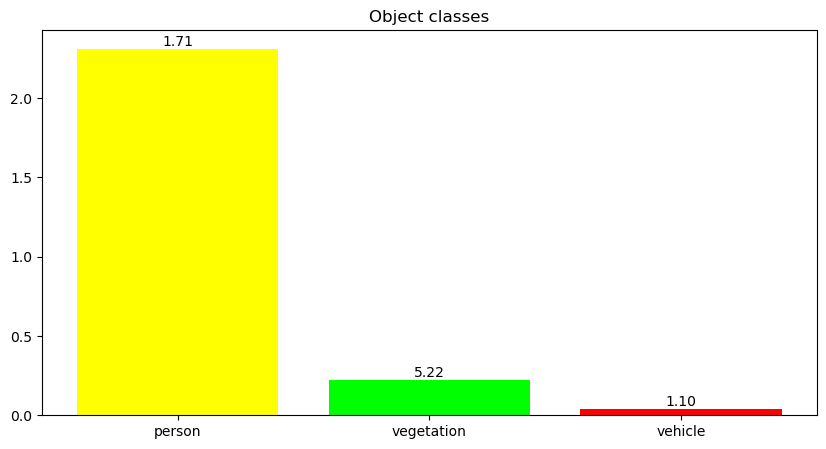

In [11]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P3Scene05.mp4"
object_class_dict, mean_class_counts = show_ground_statistics(video_path, gdino_model, sam_predictor, optical_flow_model, frame_step=FRAME_STEP, split=False, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'object_class_dict': object_class_dict, 'mean_class_counts': mean_class_counts}

120it [02:21,  1.18s/it]


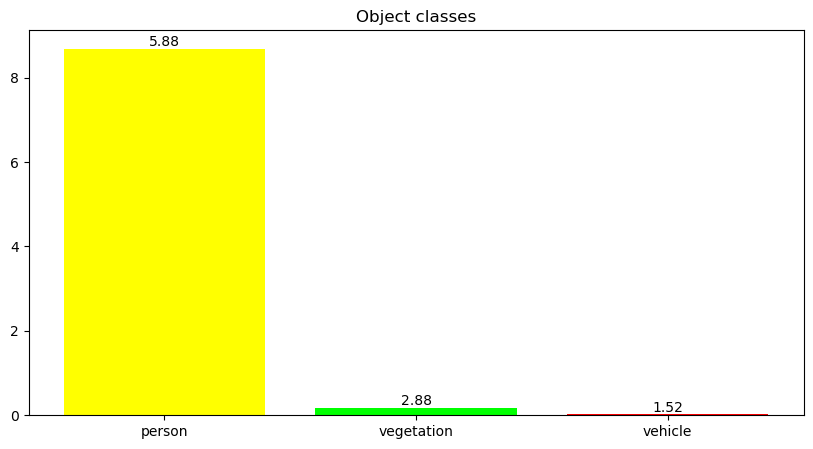

In [12]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P3Scene06.mp4"
object_class_dict, mean_class_counts = show_ground_statistics(video_path, gdino_model, sam_predictor, optical_flow_model, frame_step=FRAME_STEP, split=False, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'object_class_dict': object_class_dict, 'mean_class_counts': mean_class_counts}

120it [02:24,  1.20s/it]


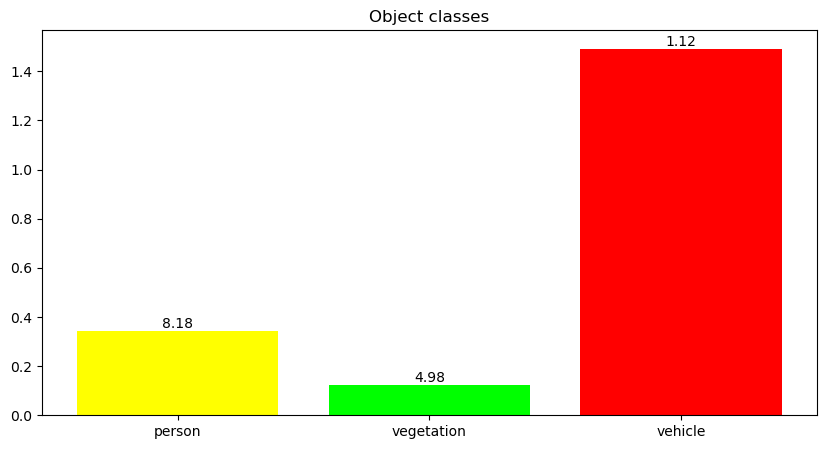

In [13]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P3Scene07.mp4"
object_class_dict, mean_class_counts = show_ground_statistics(video_path, gdino_model, sam_predictor, optical_flow_model, frame_step=FRAME_STEP, split=False, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'object_class_dict': object_class_dict, 'mean_class_counts': mean_class_counts}

121it [02:34,  1.27s/it]


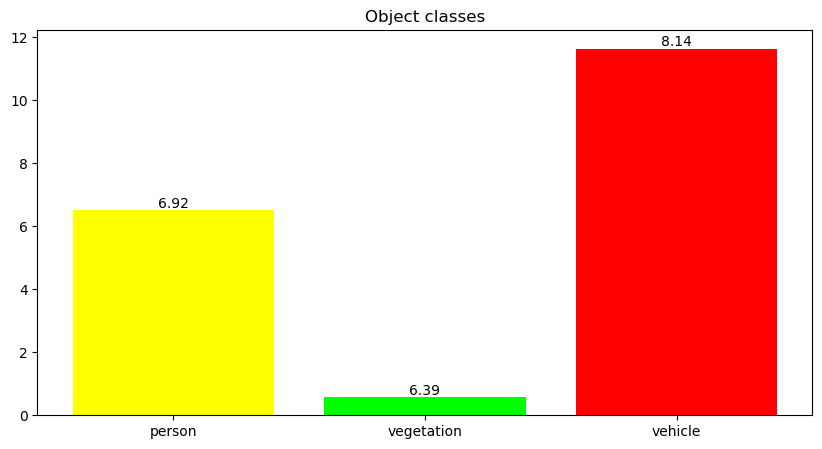

In [14]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P3Scene08.mp4"
object_class_dict, mean_class_counts = show_ground_statistics(video_path, gdino_model, sam_predictor, optical_flow_model, frame_step=FRAME_STEP, split=False, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'object_class_dict': object_class_dict, 'mean_class_counts': mean_class_counts}

121it [02:32,  1.26s/it]


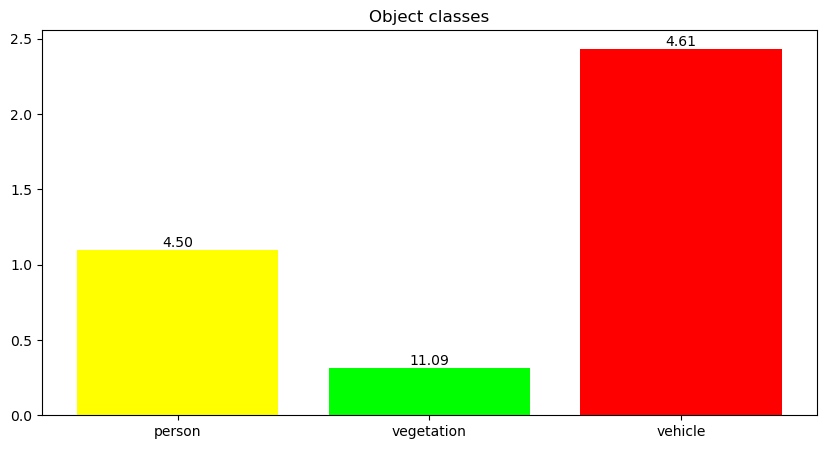

In [15]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P3Scene09.mp4"
object_class_dict, mean_class_counts = show_ground_statistics(video_path, gdino_model, sam_predictor, optical_flow_model, frame_step=FRAME_STEP, split=False, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'object_class_dict': object_class_dict, 'mean_class_counts': mean_class_counts}

121it [02:22,  1.18s/it]


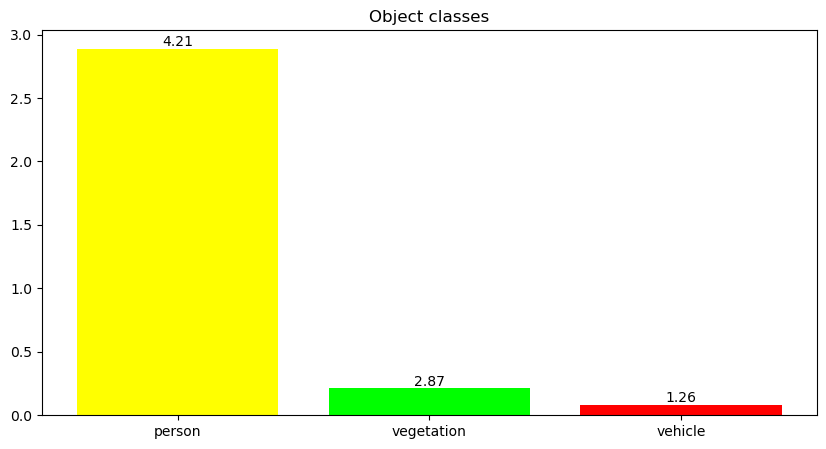

In [16]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P3Scene10.mp4"
object_class_dict, mean_class_counts = show_ground_statistics(video_path, gdino_model, sam_predictor, optical_flow_model, frame_step=FRAME_STEP, split=False, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'object_class_dict': object_class_dict, 'mean_class_counts': mean_class_counts}

120it [02:23,  1.19s/it]


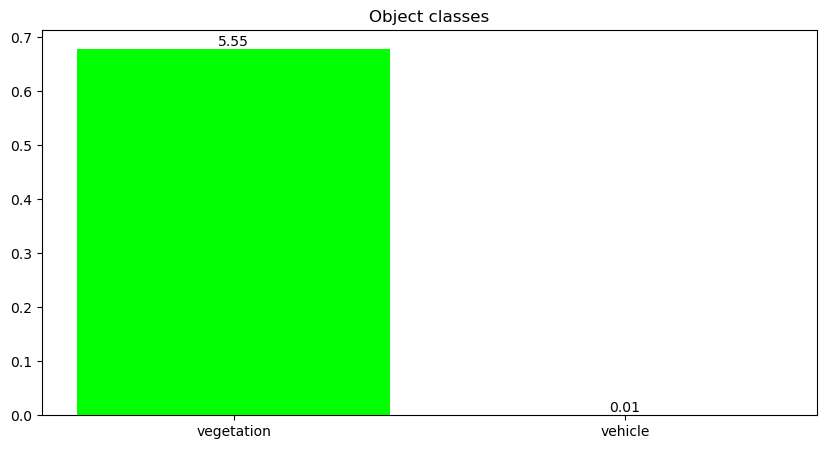

In [17]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P3Scene11.mp4"
object_class_dict, mean_class_counts = show_ground_statistics(video_path, gdino_model, sam_predictor, optical_flow_model, frame_step=FRAME_STEP, split=False, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'object_class_dict': object_class_dict, 'mean_class_counts': mean_class_counts}

120it [02:22,  1.19s/it]


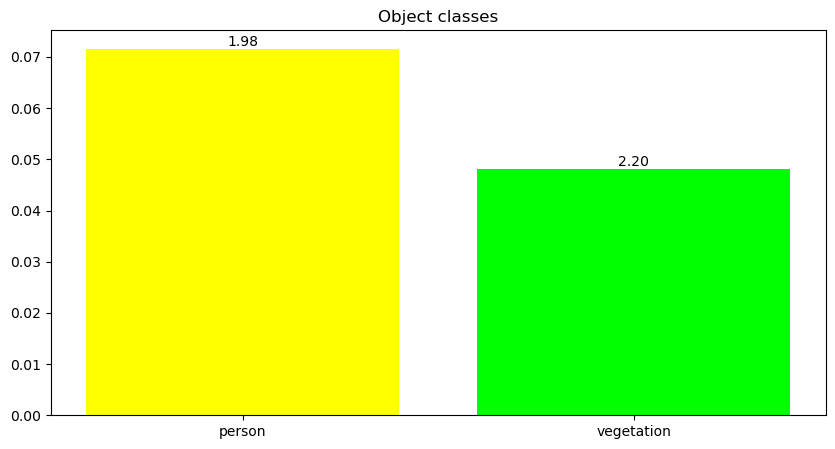

In [18]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P3Scene12.mp4"
object_class_dict, mean_class_counts = show_ground_statistics(video_path, gdino_model, sam_predictor, optical_flow_model, frame_step=FRAME_STEP, split=False, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'object_class_dict': object_class_dict, 'mean_class_counts': mean_class_counts}

121it [02:19,  1.15s/it]


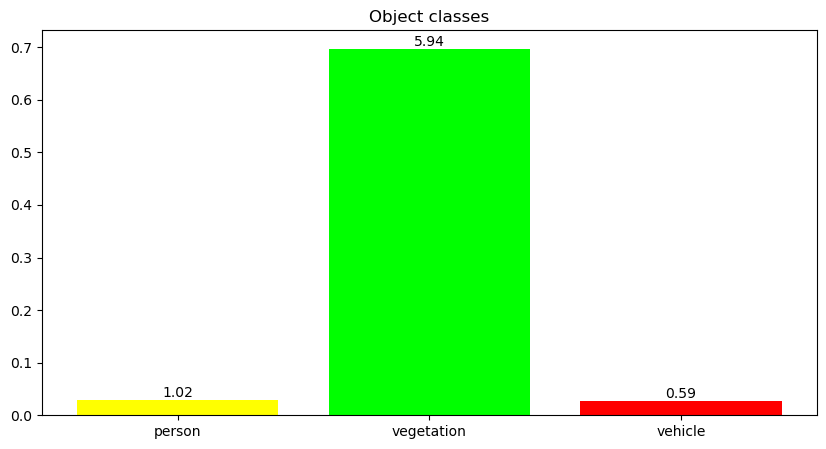

In [19]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P3Scene13.mp4"
object_class_dict, mean_class_counts = show_ground_statistics(video_path, gdino_model, sam_predictor, optical_flow_model, frame_step=FRAME_STEP, split=False, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'object_class_dict': object_class_dict, 'mean_class_counts': mean_class_counts}

121it [02:16,  1.12s/it]


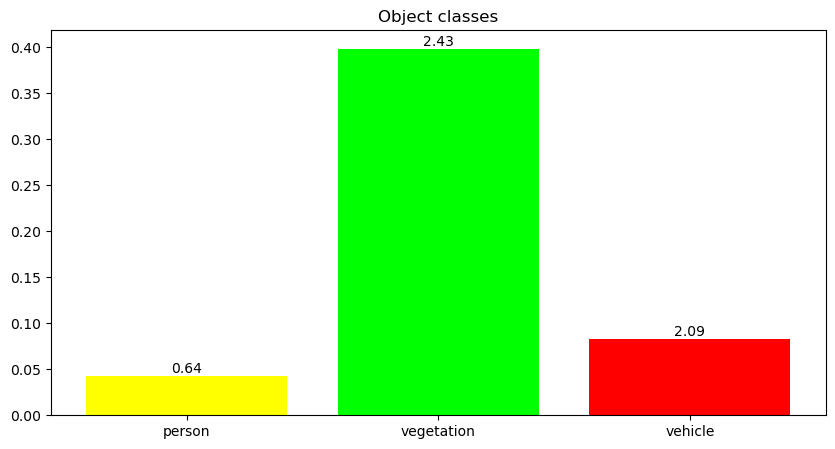

In [20]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P3Scene14.mp4"
object_class_dict, mean_class_counts = show_ground_statistics(video_path, gdino_model, sam_predictor, optical_flow_model, frame_step=FRAME_STEP, split=False, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'object_class_dict': object_class_dict, 'mean_class_counts': mean_class_counts}

120it [02:19,  1.16s/it]


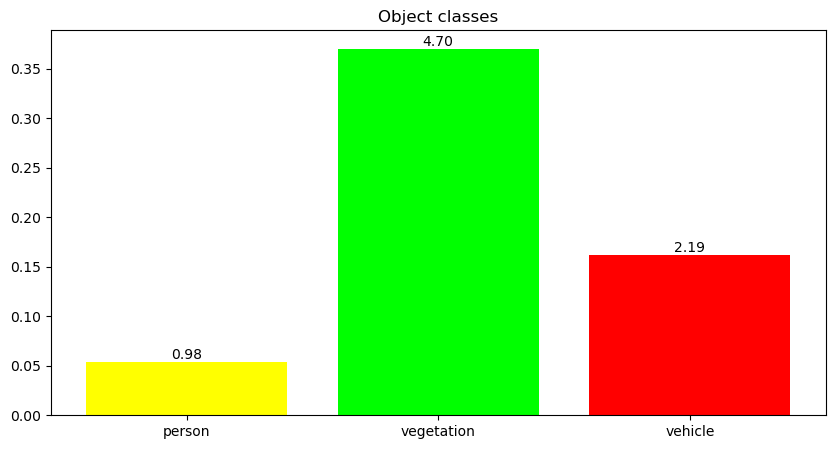

In [21]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P3Scene15.mp4"
object_class_dict, mean_class_counts = show_ground_statistics(video_path, gdino_model, sam_predictor, optical_flow_model, frame_step=FRAME_STEP, split=False, masked=True, reframed=True)
final_statistics[video_path.split('/')[-1]] = {'object_class_dict': object_class_dict, 'mean_class_counts': mean_class_counts}

In [22]:
# Save final statistics
np.save(f"../data/preprocessing/p3_gsam_scene_statistics.npy", final_statistics)

In [28]:
# Load final statistics
final_statistics = np.load(f"../data/preprocessing/p3_gsam_scene_statistics.npy", allow_pickle=True).item()

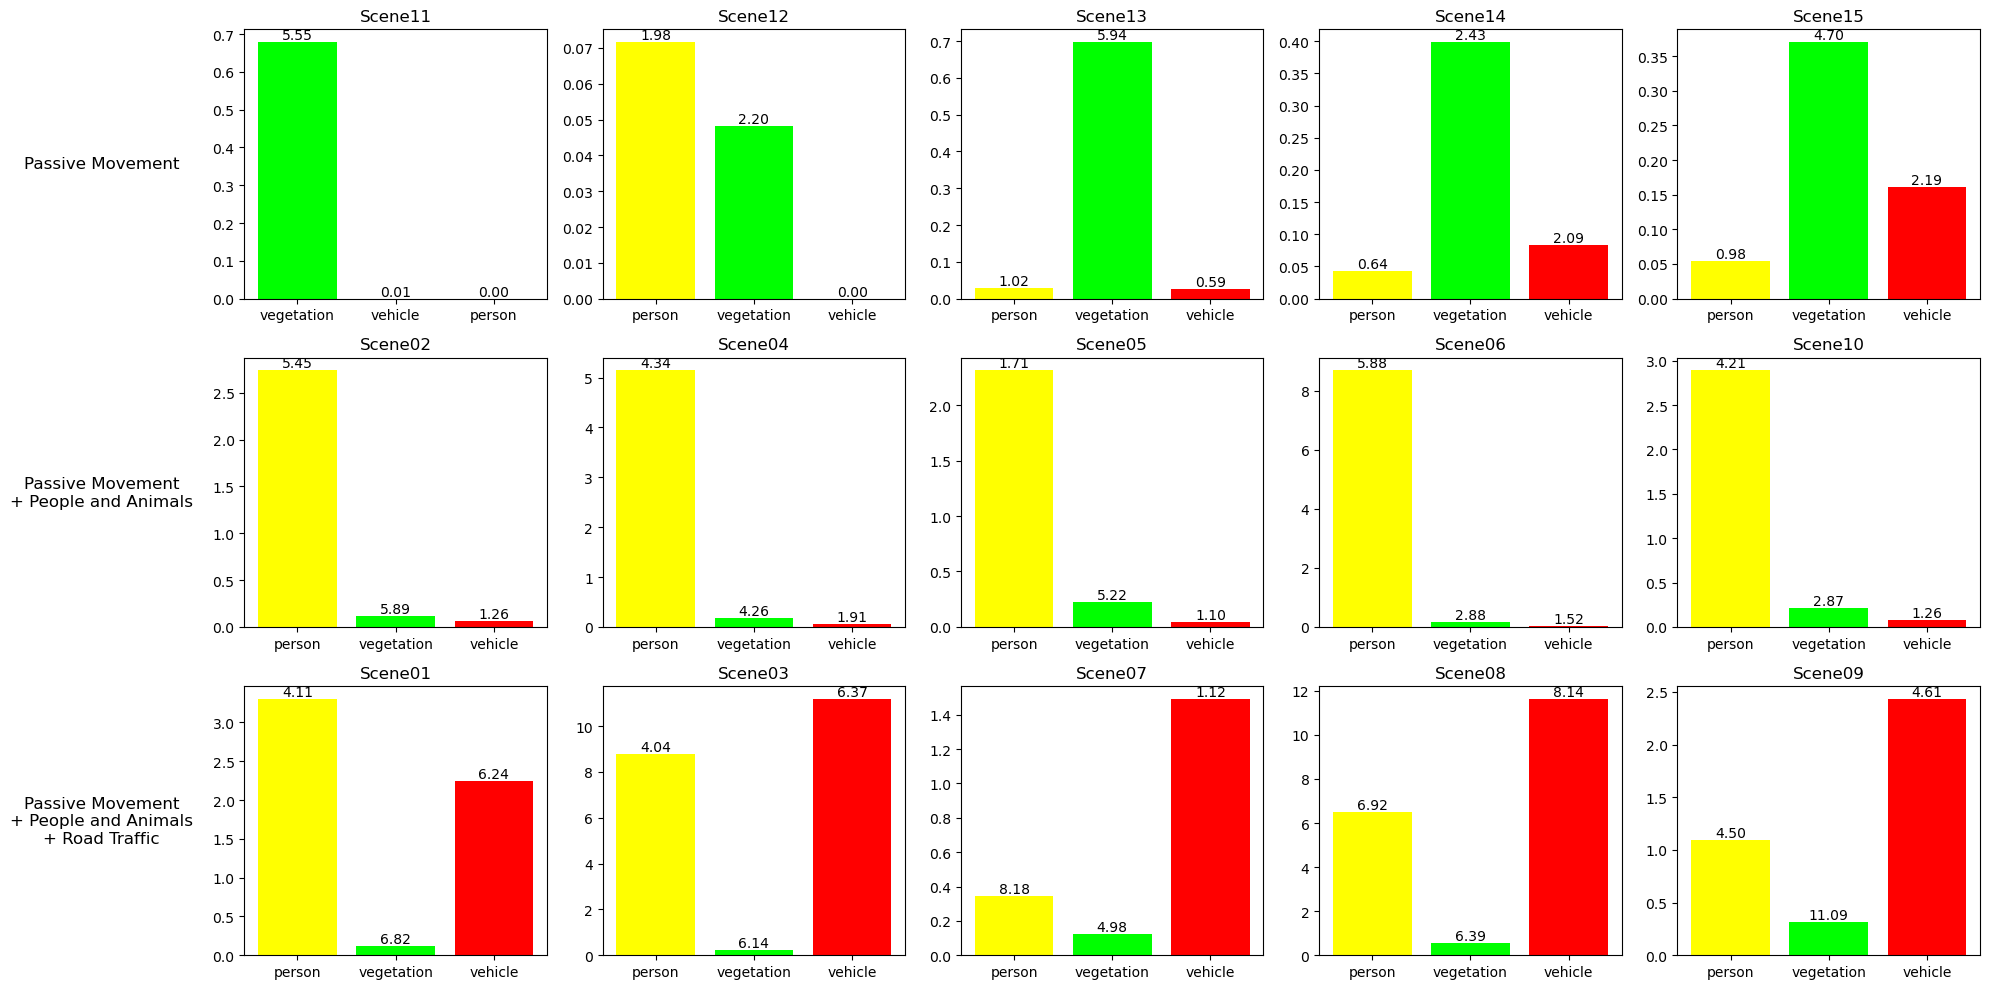

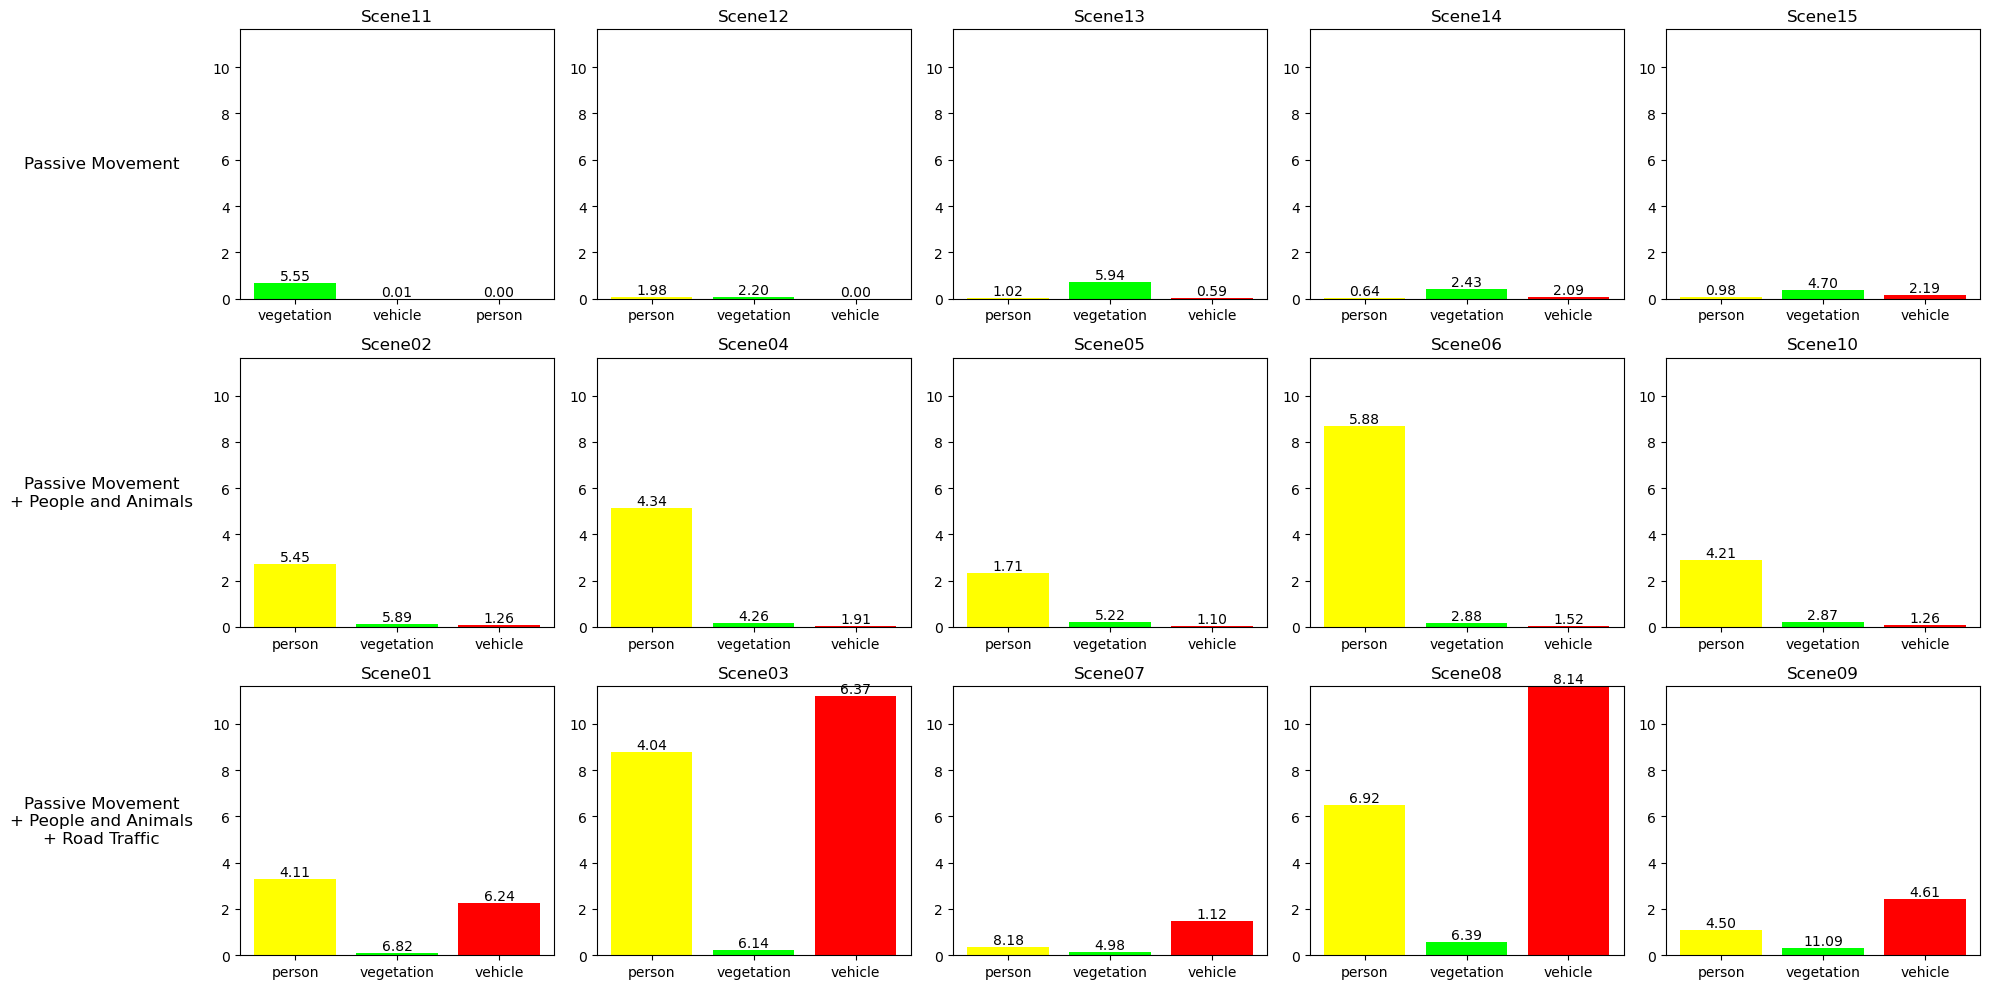

In [61]:
def plot_statistics_grid(final_statistics, scene_groups, group_titles, fix_max_y=False):
    n_rows = len(scene_groups)  # Number of rows based on the number of groups
    n_cols = len(scene_groups[0])  # Assuming each group has the same number of scenes for simplicity

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 10))  # Adjust figsize as needed

    # Determine the maximum y-value if fix_max_y is True
    max_y_value = 0
    if fix_max_y:
        for group in scene_groups:
            for scene in group:
                scene_data = final_statistics[scene]
                object_class_dict = scene_data['object_class_dict']
                max_y_value = max(max_y_value, max(object_class_dict.values()))

    # Set a large left margin to accommodate the group titles
    plt.subplots_adjust(left=0.15)

    for i, group in enumerate(scene_groups):
        for j, scene in enumerate(group):
            ax = axes[i][j]
            scene_data = final_statistics[scene]  # Get the data for the specific scene
            object_class_dict = scene_data['object_class_dict']
            mean_class_counts = scene_data['mean_class_counts']

            keys = list(object_class_dict.keys())
            values = list(object_class_dict.values())
            colors = np.array([TYPE_COLORS[key] for key in keys]) / 255.0
            
            bars = ax.bar(keys, values, color=colors)
            
            # Add mean object numbers as text on the bars
            for bar, key in zip(bars, keys):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{mean_class_counts[key]:.2f}',
                        ha='center', va='bottom')

            # Use the first column to set the group titles on the left
            if j == 0:
                # Increase the labelpad value if needed to push the label further to the left
                ax.set_ylabel(group_titles[i], fontsize=12, rotation=0, labelpad=80, verticalalignment='center')

            # Set individual title for each subplot
            ax.set_title(scene[2:-4])

            # If fix_max_y is True, set the same y-limit for all subplots
            if fix_max_y:
                ax.set_ylim(0, max_y_value)

    plt.tight_layout()
    plt.show()

scene_groups = [
    ['P3Scene11.mp4', 'P3Scene12.mp4', 'P3Scene13.mp4', 'P3Scene14.mp4', 'P3Scene15.mp4'],
    ['P3Scene02.mp4', 'P3Scene04.mp4', 'P3Scene05.mp4', 'P3Scene06.mp4', 'P3Scene10.mp4'],
    ['P3Scene01.mp4', 'P3Scene03.mp4', 'P3Scene07.mp4', 'P3Scene08.mp4', 'P3Scene09.mp4']
]

group_titles = [
    "Passive Movement",
    "Passive Movement\n+ People and Animals",
    "Passive Movement\n+ People and Animals\n+ Road Traffic"
]

plot_statistics_grid(final_statistics, scene_groups, group_titles, fix_max_y=False)
plot_statistics_grid(final_statistics, scene_groups, group_titles, fix_max_y=True)


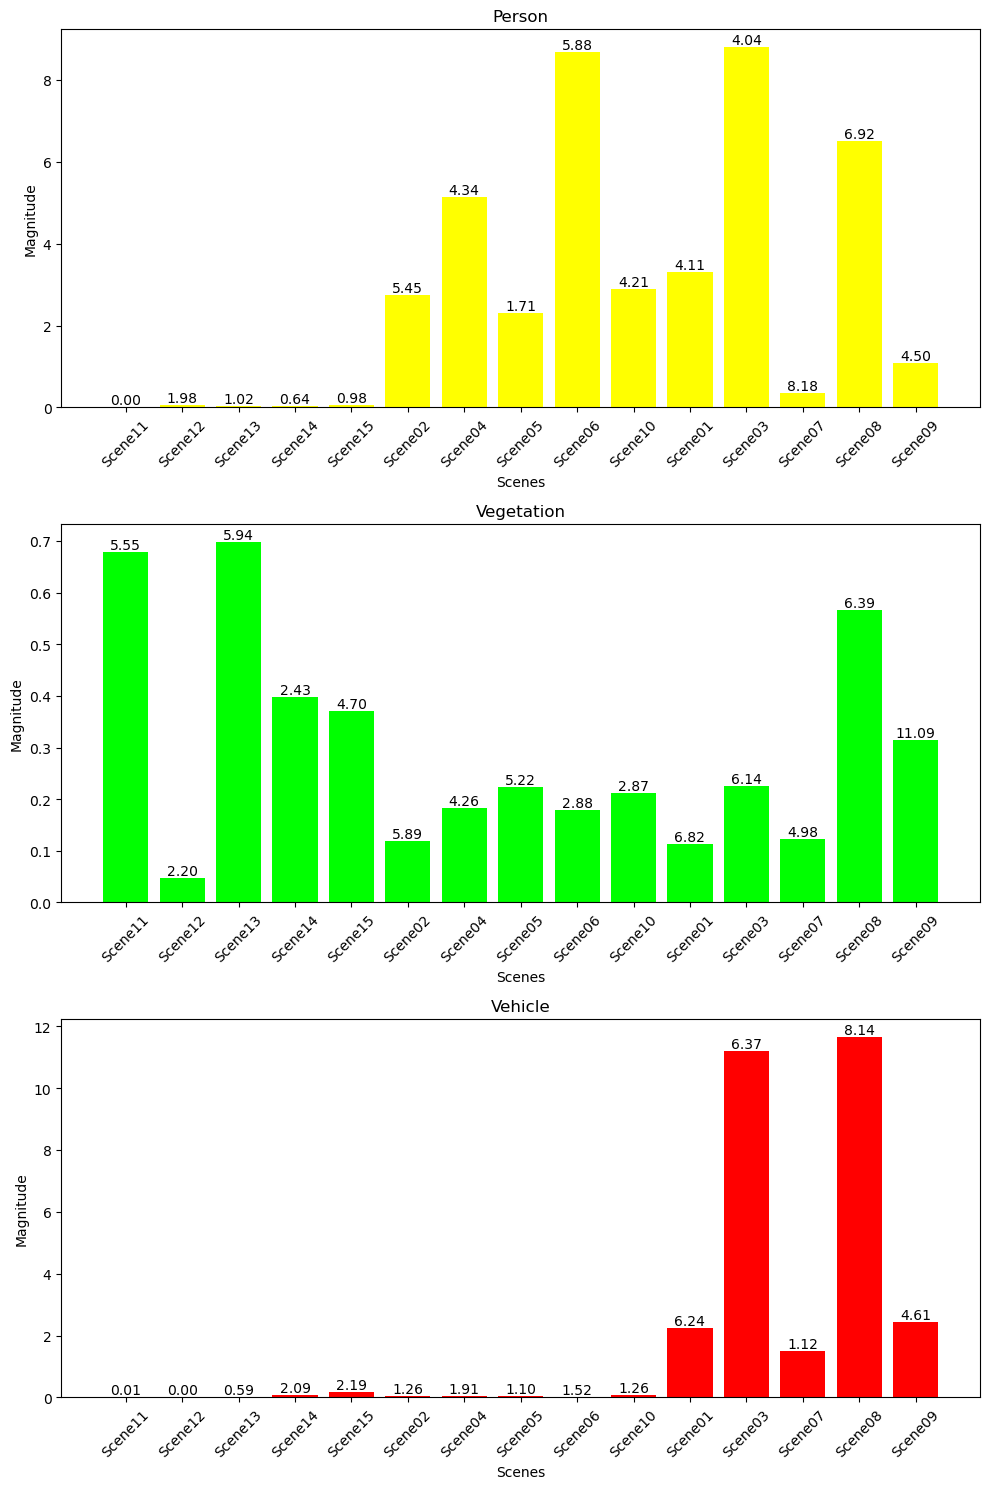

In [64]:
def plot_class_comparison(final_statistics, scene_list):
    # Define object classes to plot
    object_classes = ['person', 'vegetation', 'vehicle']
    
    # Data preparation
    data = {obj_class: [] for obj_class in object_classes}
    mean_counts = {obj_class: [] for obj_class in object_classes}
    for scene in scene_list:
        for obj_class in object_classes:
            data[obj_class].append(final_statistics[scene]['object_class_dict'].get(obj_class, 0))
            mean_counts[obj_class].append(final_statistics[scene]['mean_class_counts'].get(obj_class, 0))

    # Create subplots for each object class
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

    for i, obj_class in enumerate(object_classes):
        bars = axes[i].bar(scene_list, data[obj_class], color=np.array(TYPE_COLORS[obj_class]) / 255.0)
        axes[i].set_title(obj_class.capitalize())
        axes[i].set_ylabel('Magnitude')
        axes[i].set_xticks(np.arange(len(scene_list)))
        axes[i].set_xticklabels([scene[2:-4] for scene in scene_list], rotation=45)
        
        # Add mean object numbers as text on the bars
        for bar, mean_count in zip(bars, mean_counts[obj_class]):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width() / 2., height,
                         f'{mean_count:.2f}', ha='center', va='bottom')

    axes[0].set_xlabel('Scenes')
    axes[1].set_xlabel('Scenes')
    axes[2].set_xlabel('Scenes')

    plt.tight_layout()
    plt.show()

scene_list = scene_groups = ['P3Scene11.mp4', 'P3Scene12.mp4', 'P3Scene13.mp4', 'P3Scene14.mp4', 'P3Scene15.mp4', 
                             'P3Scene02.mp4', 'P3Scene04.mp4', 'P3Scene05.mp4', 'P3Scene06.mp4', 'P3Scene10.mp4', 
                             'P3Scene01.mp4', 'P3Scene03.mp4', 'P3Scene07.mp4', 'P3Scene08.mp4', 'P3Scene09.mp4']
plot_class_comparison(final_statistics, scene_list)

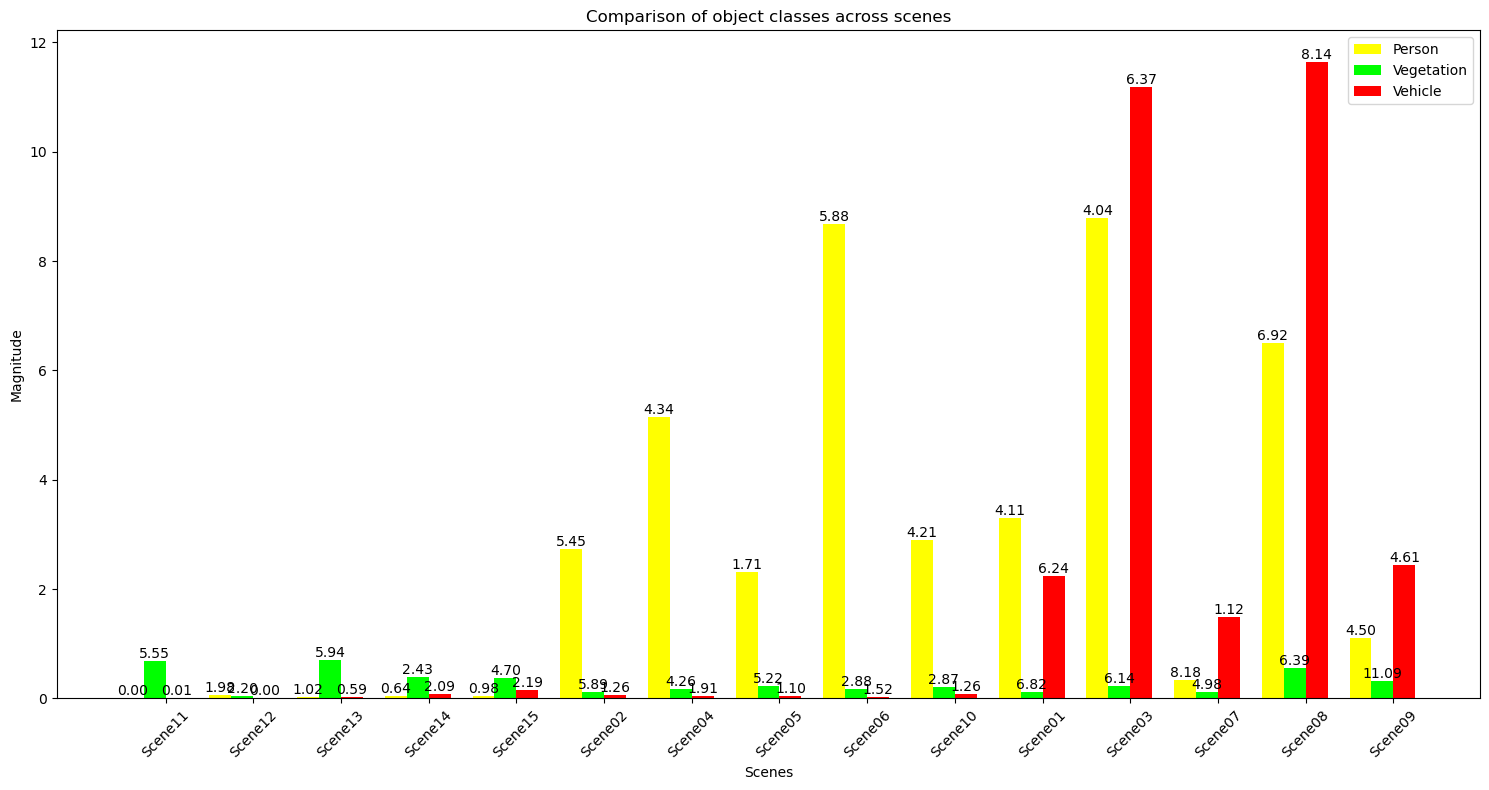

In [65]:
def plot_class_comparison(final_statistics, scene_list):
    # Define object classes to plot
    object_classes = ['person', 'vegetation', 'vehicle']
    
    # Number of object classes
    n_classes = len(object_classes)
    
    # Data preparation
    data = {obj_class: [] for obj_class in object_classes}
    mean_counts = {obj_class: [] for obj_class in object_classes}
    
    for scene in scene_list:
        for obj_class in object_classes:
            data[obj_class].append(final_statistics[scene]['object_class_dict'].get(obj_class, 0))
            mean_counts[obj_class].append(final_statistics[scene]['mean_class_counts'].get(obj_class, 0))

    # Create a figure and a single subplot
    fig, ax = plt.subplots(figsize=(15, 8))

    # Set the positions for the groups
    indices = np.arange(len(scene_list))
    bar_width = 0.25  # The width of the bars
    offset = bar_width * n_classes / 2  # Offset to center the group around the tick

    for i, obj_class in enumerate(object_classes):
        # Calculate the position for each bar
        bar_positions = indices - offset + i * bar_width
        
        # Plot the bars for the current object class
        bars = ax.bar(bar_positions, data[obj_class], bar_width, label=obj_class.capitalize(), color=np.array(TYPE_COLORS[obj_class]) / 255.0)
        
        # Add mean object numbers as text on the bars
        for bar, mean_count in zip(bars, mean_counts[obj_class]):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    f'{mean_count:.2f}', ha='center', va='bottom')

    # Set the x-axis ticks to be in the center of each group and rotate them for better visibility
    ax.set_xticks(indices)
    ax.set_xticklabels([scene[2:-4] for scene in scene_list], rotation=45)
    
    # Adding the x-axis and y-axis labels
    ax.set_xlabel('Scenes')
    ax.set_ylabel('Magnitude')

    # Add a legend
    ax.legend()

    # Set the title of the plot
    ax.set_title('Comparison of object classes across scenes')

    plt.tight_layout()
    plt.show()

# Usage
scene_list = [
    'P3Scene11.mp4', 'P3Scene12.mp4', 'P3Scene13.mp4', 
    'P3Scene14.mp4', 'P3Scene15.mp4', 'P3Scene02.mp4', 
    'P3Scene04.mp4', 'P3Scene05.mp4', 'P3Scene06.mp4', 
    'P3Scene10.mp4', 'P3Scene01.mp4', 'P3Scene03.mp4', 
    'P3Scene07.mp4', 'P3Scene08.mp4', 'P3Scene09.mp4'
]
plot_class_comparison(final_statistics, scene_list)